In [1]:
import sys
sys.path.append('/Users/laurenthericourt/projets/trading/trading')
import warnings
warnings.filterwarnings('ignore')

import psycopg2
import numpy as np
import pandas as pd
from pandas.io.sql import read_sql
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from config.load import load_conf
from db.utils import get_uri_db
from utils.utils import AnnualGranularity, get_candles
from indicator.oscillator import Atr, Macd, Rsi, Stochastic, Obv
from indicator.trend import BollingerBands, Adx, Slope

In [2]:
load_conf('../config/configuration.yaml')
dsn = get_uri_db()
schema = 'trading'

# Get data

In [3]:
start_date = '2015-01-01'
end_date = '2021-01-01'

all_candles = get_candles(dsn, schema, start_date, end_date)

In [4]:
candles = all_candles[(all_candles['table'] == 'candle') & (all_candles['symbol'] == 'EUR/USD')]

# Compute indicators

In [5]:
def compute_sign_changement(data, col, span):
    data['sign'] = np.where(data[col] < 0, -1, 1)
    sign_sum = data['sign'].rolling(span).sum()
    change_sign = np.where(np.abs(sign_sum) != span, 1, 0)
    change_sign_pos = np.where((change_sign == 1) & (data[col] > 0), 1, 0)
    change_sign_neg = np.where((change_sign == 1) & (data[col] < 0), 1, 0)
    del data['sign']
    return change_sign_pos, change_sign_neg

## ATR

In [6]:
def atr_features(candles):
    atr = Atr(candles, 'close')
    for avg_type in ['ma', 'ewm', 'wws']:
        candles.loc[:, f'atr_7_{avg_type}'], _ = atr.compute(7, avg_type)
        candles.loc[:, f'atr_14_{avg_type}'], _ = atr.compute(14, avg_type)
        candles.loc[:, f'atr_28_{avg_type}'], _ = atr.compute(28, avg_type)
    return candles

## MACD

In [7]:
def macd_features(candles):
    macd = Macd(candles, 'close')
    _, _, candles.loc[:, 'macd_hist'] = macd.compute()

    for span in [2, 5, 10]:
        candles[f'macd_change_sign_pos_{span}'], candles[f'macd_change_sign_neg_{span}'] = compute_sign_changement(candles, 'macd_hist', span)
    return candles    

## Moyennes mobiles

In [8]:
def moyenne_mobile_features(candles):
    for span in [5, 10, 20, 50, 100, 200]:
        candles[f'ma_{span}'] = candles['close'].rolling(span, min_periods=span).mean()
        
    # tendances haussières
    candles['above_ma_5'] = np.where(candles['close'] > candles['ma_5'], 1, 0)
    candles['above_ma_200'] = np.where(candles['close'] > candles['ma_200'], 1, 0)
    candles['ma_10_above_ma_100'] = np.where(candles['ma_10'] > candles['ma_100'], 1, 0)
    candles['ma_20_above_ma_50'] = np.where(candles['ma_20'] > candles['ma_50'], 1, 0)

    # tendances baissières
    candles['below_ma_5'] = np.where(candles['close'] < candles['ma_5'], 1, 0)
    candles['below_ma_200'] = np.where(candles['close'] < candles['ma_200'], 1, 0)
    candles['ma_10_velow_ma_100'] = np.where(candles['ma_10'] < candles['ma_100'], 1, 0)
    candles['ma_20_below_ma_50'] = np.where(candles['ma_20'] < candles['ma_50'], 1, 0)
    
    # Signaux d'achats / ventes
    candles['close_minus_ma_20'] = candles['close'] - candles['ma_20']
    candles['close_minus_ma_200'] = candles['close'] - candles['ma_200']
    candles['ma_50_ma_100'] = candles['ma_50'] - candles['ma_100']
    candles['ma_50_ma_200'] = candles['ma_50'] - candles['ma_200']
    
    for span in [2, 5, 10]:
        candles[f'close_ma_20_change_sign_pos_{span}'], candles[f'close_ma_20_change_sign_neg_{span}'] = compute_sign_changement(candles, 'close_minus_ma_20', span)
        candles[f'close_ma_200_change_sign_pos_{span}'], candles[f'close_ma_200_change_sign_neg_{span}'] = compute_sign_changement(candles, 'close_minus_ma_200', span)
        candles[f'ma_50_ma_100_change_sign_pos_{span}'], candles[f'ma_50_ma_100_change_sign_neg_{span}'] = compute_sign_changement(candles, 'ma_50_ma_100', span)
        candles[f'ma_50_ma_200_change_sign_pos_{span}'], candles[f'ma_50_ma_200_change_sign_neg_{span}'] = compute_sign_changement(candles, 'ma_50_ma_200', span)
    
    for span in [5, 10, 20, 50, 100, 200]:
        del candles[f'ma_{span}']
    
    return candles

### Analyse moyenne mobile

In [9]:
candles = all_candles[(all_candles['table'] == 'candle1h') & (all_candles['symbol'] == 'EUR/USD')]
candles = moyenne_mobile_features(candles)

In [10]:
candles.head()

,table,date,symbol,open,close,low,high,tickqty,above_ma_5,above_ma_200,ma_10_above_ma_100,ma_20_above_ma_50,below_ma_5,below_ma_200,ma_10_velow_ma_100,ma_20_below_ma_50,close_minus_ma_20,close_minus_ma_200,ma_50_ma_100,ma_50_ma_200,close_ma_20_change_sign_pos_2,close_ma_20_change_sign_neg_2,close_ma_200_change_sign_pos_2,close_ma_200_change_sign_neg_2,ma_50_ma_100_change_sign_pos_2,ma_50_ma_100_change_sign_neg_2,ma_50_ma_200_change_sign_pos_2,ma_50_ma_200_change_sign_neg_2,close_ma_20_change_sign_pos_5,close_ma_20_change_sign_neg_5,close_ma_200_change_sign_pos_5,close_ma_200_change_sign_neg_5,ma_50_ma_100_change_sign_pos_5,ma_50_ma_100_change_sign_neg_5,ma_50_ma_200_change_sign_pos_5,ma_50_ma_200_change_sign_neg_5,close_ma_20_change_sign_pos_10,close_ma_20_change_sign_neg_10,close_ma_200_change_sign_pos_10,close_ma_200_change_sign_neg_10,ma_50_ma_100_change_sign_pos_10,ma_50_ma_100_change_sign_neg_10,ma_50_ma_200_change_sign_pos_10,ma_50_ma_200_change_sign_neg_10
5456054,candle1h,2015-01-02 03:00:00,EUR/USD,1.21008,1.20586,1.20576,1.21008,1068,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5456055,candle1h,2015-01-02 04:00:00,EUR/USD,1.20586,1.20540,1.20501,1.20609,4281,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5456056,candle1h,2015-01-02 05:00:00,EUR/USD,1.20540,1.20531,1.20470,1.20566,4253,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5456057,candle1h,2015-01-02 06:00:00,EUR/USD,1.20531,1.20556,1.20496,1.20587,4324,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5456058,candle1h,2015-01-02 07:00:00,EUR/USD,1.20556,1.20571,1.20356,1.20591,11343,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
for w in [3, 5, 10, 20, 40]:
    candles[f'highest_{w}'] = candles['high'][::-1].rolling(window=w).max()[::-1]
    candles[f'lowest_{w}'] = candles['low'][::-1].rolling(window=w).min()[::-1]
    candles[f'diff_highest_{w}'] = candles[f'highest_{w}'] - candles['close']
    candles[f'diff_lowest_{w}'] = candles['close'] - candles[f'lowest_{w}']
    

In [12]:
candles['indicator'] = candles['close_ma_20_change_sign_neg_2']
print(candles[candles['indicator'] == 1].shape)
candles['indicator_roll'] = candles['indicator'].rolling(window=100).max()
candles['indicator'] = np.where((candles['indicator'] == 1) & (candles['indicator_roll'] == 1), 1, 0)
print(candles[candles['indicator'] == 1].shape)

(2245, 65)
(2240, 66)


In [13]:
candles.loc[candles['indicator'] == 1, ['diff_highest_3', 'diff_lowest_3',
                                                            'diff_highest_5', 'diff_lowest_5', 
                                                            'diff_highest_10', 'diff_lowest_10',
                                                            'diff_highest_20', 'diff_lowest_20',
                                                            'diff_highest_40', 'diff_lowest_40']].describe()

,diff_highest_3,diff_lowest_3,diff_highest_5,diff_lowest_5,diff_highest_10,diff_lowest_10,diff_highest_20,diff_lowest_20,diff_highest_40,diff_lowest_40
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2238.000000,2238.000000,2237.000000,2237.000000
mean,0.002093,0.001329,0.002469,0.001848,0.003264,0.002733,0.004279,0.003709,0.006029,0.005444
std,0.001728,0.001396,0.001953,0.002084,0.002731,0.003008,0.003666,0.003652,0.005297,0.005055
min,0.000160,0.000000,0.000160,0.000000,0.000160,0.000000,0.000160,0.000000,0.000160,0.000000
25%,0.001027,0.000460,0.001190,0.000600,0.001470,0.000870,0.001860,0.001250,0.002380,0.001900
50%,0.001620,0.000910,0.001900,0.001230,0.002485,0.001865,0.003200,0.002660,0.004540,0.004150
75%,0.002563,0.001743,0.003150,0.002400,0.004283,0.003560,0.005690,0.005098,0.008170,0.007540
max,0.017700,0.015300,0.017700,0.042130,0.046000,0.044120,0.046000,0.044120,0.049440,0.047630


In [14]:
candles.loc[candles['indicator'] == 1, ['diff_highest_3', 'diff_lowest_3',
                                                            'diff_highest_5', 'diff_lowest_5', 
                                                            'diff_highest_10', 'diff_lowest_10',
                                                            'diff_highest_20', 'diff_lowest_20',
                                                            'diff_highest_40', 'diff_lowest_40']].describe()

,diff_highest_3,diff_lowest_3,diff_highest_5,diff_lowest_5,diff_highest_10,diff_lowest_10,diff_highest_20,diff_lowest_20,diff_highest_40,diff_lowest_40
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2238.000000,2238.000000,2237.000000,2237.000000
mean,0.002093,0.001329,0.002469,0.001848,0.003264,0.002733,0.004279,0.003709,0.006029,0.005444
std,0.001728,0.001396,0.001953,0.002084,0.002731,0.003008,0.003666,0.003652,0.005297,0.005055
min,0.000160,0.000000,0.000160,0.000000,0.000160,0.000000,0.000160,0.000000,0.000160,0.000000
25%,0.001027,0.000460,0.001190,0.000600,0.001470,0.000870,0.001860,0.001250,0.002380,0.001900
50%,0.001620,0.000910,0.001900,0.001230,0.002485,0.001865,0.003200,0.002660,0.004540,0.004150
75%,0.002563,0.001743,0.003150,0.002400,0.004283,0.003560,0.005690,0.005098,0.008170,0.007540
max,0.017700,0.015300,0.017700,0.042130,0.046000,0.044120,0.046000,0.044120,0.049440,0.047630


## RSI

In [15]:
def rsi_features(candles):
    rsi = Rsi(candles, 'close')
    rsi_val = rsi.compute()
    candles['rsi'] = rsi_val
    candles['rsi_minus_70'] = candles['rsi'] - 70
    candles['rsi_minus_30'] = candles['rsi'] - 30
    for span in [2, 5]:
        _, candles[f'rsi_back_below_70_{span}'] = compute_sign_changement(candles, 'rsi_minus_70', span)
        candles[f'rsi_back_above_30_{span}'], _ = compute_sign_changement(candles, 'rsi_minus_30', span)
    del candles['rsi_minus_70']
    del candles['rsi_minus_30']
    
    return candles

## Stochastic

In [16]:
def stochastic_features(candles):
    stoch = Stochastic(candles)
    candles['stoch'], candles['stoch_ma'], candles['stoch_hist'] = stoch.compute()
    for span in [2, 5]:
        candles[f'stoch_change_sign_pos_{span}'], candles[f'stoch_change_sign_neg_{span}'] = compute_sign_changement(candles, 'stoch_hist', span)

    candles['stoch_minus_80'] = candles['stoch'] - 80
    candles['stoch_minus_20'] = candles['stoch'] - 20
    for span in [2, 5]:
        _, candles[f'stoch_back_below_80_{span}'] = compute_sign_changement(candles, 'stoch_minus_80', span)
        candles[f'stoch_back_above_20_{span}'], _ = compute_sign_changement(candles, 'stoch_minus_20', span)

    del candles['stoch_minus_80']
    del candles['stoch_minus_20']
    
    return candles

## Obv

In [17]:
def obv_features(candles):
    obv = Obv(candles)
    candles['obv'] = obv.compute()
    candles['obv_pct'] = candles['obv'].pct_change()
    del candles['obv']
    return candles

## Bollinger Bands

In [18]:
def bollinger_bands_features(candles):
    _, bb_up, bb_down = BollingerBands(candles, 'close').compute()
    candles['bb_up_minus_close'] = bb_up - candles['close']
    candles['close_minus_bb_down'] = candles['close'] - bb_down
    candles['above_bb_up'] = np.where(candles['close'] > bb_up, 1, 0) 
    candles['below_bb_down'] = np.where(candles['close'] < bb_down, 1, 0)
    return candles

## ADX

In [19]:
def adx_features(candles):
    candles['dm_plus_norm'], candles['dm_minus_norm'], candles['adx'] = Adx(candles).compute()
    return candles

## Slope

In [207]:
candles['slope_5'] = Slope(candles).compute(5)

KeyboardInterrupt: 

## All features

In [20]:
def compute_features_one_time_level(candles):
    candles = atr_features(candles)
    candles = macd_features(candles)
    candles = moyenne_mobile_features(candles)
    candles = rsi_features(candles)
    candles = stochastic_features(candles)
    candles = obv_features(candles)
    candles = bollinger_bands_features(candles)
    candles = adx_features(candles)
    
    return candles

In [21]:
candles_features = candles.copy()
candles_features = compute_features_one_time_level(candles_features)

In [22]:
def decompose_date(candles):
    candles['15min'] = 15 * (candles['date'].dt.minute / 15).astype(int)
    candles['30min'] = 30 * (candles['date'].dt.minute / 30).astype(int)
    candles['1h'] = (candles['date'].dt.hour).astype(int)
    candles['4h'] = 4 * (candles['date'].dt.hour / 4).astype(int)
    candles['date_only'] = candles['date'].dt.date
    return candles

In [23]:
candles1h = all_candles[(all_candles['table'] == 'candle1h') & (all_candles['symbol'] == 'EUR/USD')]
candles1h = compute_features_one_time_level(candles1h)

In [104]:
candles15min = all_candles[(all_candles['table'] == 'candle15m') & (all_candles['symbol'] == 'EUR/USD')]

In [105]:
candles15min = compute_features_one_dimension(candles15min)

In [107]:
candles15min = decompose_date(candles15min)

In [108]:
candles15min.tail()

,table,date,symbol,open,close,low,high,tickqty,atr_7_ma,atr_14_ma,atr_28_ma,atr_7_ewm,atr_14_ewm,atr_28_ewm,atr_7_wws,atr_14_wws,atr_28_wws,macd_hist,macd_change_sign_pos_2,macd_change_sign_neg_2,macd_change_sign_pos_5,macd_change_sign_neg_5,macd_change_sign_pos_10,macd_change_sign_neg_10,above_ma_5,above_ma_200,ma_10_above_ma_100,ma_20_above_ma_50,below_ma_5,below_ma_200,ma_10_velow_ma_100,ma_20_below_ma_50,close_minus_ma_20,close_minus_ma_200,ma_50_ma_100,ma_50_ma_200,close_ma_20_change_sign_pos_2,close_ma_20_change_sign_neg_2,close_ma_200_change_sign_pos_2,close_ma_200_change_sign_neg_2,ma_50_ma_100_change_sign_pos_2,ma_50_ma_100_change_sign_neg_2,ma_50_ma_200_change_sign_pos_2,ma_50_ma_200_change_sign_neg_2,close_ma_20_change_sign_pos_5,close_ma_20_change_sign_neg_5,close_ma_200_change_sign_pos_5,close_ma_200_change_sign_neg_5,ma_50_ma_100_change_sign_pos_5,ma_50_ma_100_change_sign_neg_5,ma_50_ma_200_change_sign_pos_5,ma_50_ma_200_change_sign_neg_5,close_ma_20_change_sign_pos_10,close_ma_20_change_sign_neg_10,close_ma_200_change_sign_pos_10,close_ma_200_change_sign_neg_10,ma_50_ma_100_change_sign_pos_10,ma_50_ma_100_change_sign_neg_10,ma_50_ma_200_change_sign_pos_10,ma_50_ma_200_change_sign_neg_10,rsi,rsi_back_below_70_2,rsi_back_above_30_2,rsi_back_below_70_5,rsi_back_above_30_5,stoch,stoch_ma,stoch_hist,stoch_change_sign_pos_2,stoch_change_sign_neg_2,stoch_change_sign_pos_5,stoch_change_sign_neg_5,stoch_back_below_80_2,stoch_back_above_20_2,stoch_back_below_80_5,stoch_back_above_20_5,obv_pct,bb_up_minus_close,close_minus_bb_down,above_bb_up,below_bb_down,dm_plus_norm,dm_minus_norm,adx,15min,30min,1h,4h,date_only
3367187,candle15m,2021-01-05 22:45:00,EUR/USD,1.22977,1.22977,1.22946,1.22986,118,0.000483,0.000484,0.000596,0.000458,0.000502,0.000588,0.000496,0.000583,0.000664,-0.000085,0,0,0,0,0,0,0,1,1,1,1,0,0,0,-0.000045,0.002779,0.001039,0.001670,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,55.763368,0,0,0,0,46.913580,47.325103,-4.115226e-01,0,0,0,1,0,0,0,0,0.000000,0.000708,0.000618,0,0,23.234245,17.074413,21.857044,45,30,22,20,2021-01-05
3367188,candle15m,2021-01-05 23:00:00,EUR/USD,1.22975,1.22977,1.22963,1.22990,851,0.000451,0.000469,0.000583,0.000411,0.000471,0.000566,0.000463,0.000560,0.000650,-0.000082,0,0,0,0,0,0,0,1,1,1,1,0,0,0,-0.000032,0.002753,0.001023,0.001675,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,55.763368,0,0,0,0,46.913580,46.913580,-2.621903e-12,0,0,0,1,0,0,0,0,0.000000,0.000686,0.000623,0,0,22.944459,16.486734,21.465627,0,0,23,20,2021-01-05
3367189,candle15m,2021-01-05 23:15:00,EUR/USD,1.22976,1.22983,1.22952,1.23006,1507,0.000487,0.000474,0.000574,0.000443,0.000481,0.000564,0.000474,0.000559,0.000646,-0.000076,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0.000052,0.002786,0.001018,0.001688,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,56.681791,0,0,0,0,50.617284,48.148148,2.469136e+00,1,0,1,0,0,0,0,0,0.002601,0.000559,0.000663,0,0,23.405844,15.348883,21.417341,15,0,23,20,2021-01-05
3367190,candle15m,2021-01-05 23:30:00,EUR/USD,1.22983,1.22986,1.22971,1.23003,908,0.000433,0.000447,0.000539,0.000413,0.000459,0.000547,0.000452,0.000542,0.000634,-0.000069,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0.000081,0.002789,0.001005,0.001696,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,57.160705,0,0,0,0,61.594203,53.041689,8.552514e+00,0,0,1,0,0,0,0,0,0.001563,0.000531,0.000693,0,0,22.418435,14.701368,21.372504,30,30,23,20,2021-01-05
3367191,candle15m,2021-01-05 23:45:00,EUR/USD,1.22986,1.22993,1.22973,1.23022,950,0.000379,0.000456,0.000533,0.000432,0.000463,0.000543,0.000458,0.000538,0.000629,-0.000059,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0.000124,0.002830,0.000989,0.001698,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,58.318656,0,0,0,0,66.666667,59.626051,7.040615e+00,0,0,1,0,0,0,0,0,0.001633,0.000464,0.000713,0,0,23.482336,13.745158,21.714174,45,30,23,20,2021-01-05


In [109]:
decompose_date(candles_features).tail()

,table,date,symbol,open,close,low,high,tickqty,atr_7_ma,atr_14_ma,atr_28_ma,atr_7_ewm,atr_14_ewm,atr_28_ewm,atr_7_wws,atr_14_wws,atr_28_wws,macd_hist,macd_change_sign_pos_2,macd_change_sign_neg_2,macd_change_sign_pos_5,macd_change_sign_neg_5,macd_change_sign_pos_10,macd_change_sign_neg_10,above_ma_5,above_ma_200,ma_10_above_ma_100,ma_20_above_ma_50,below_ma_5,below_ma_200,ma_10_velow_ma_100,ma_20_below_ma_50,close_minus_ma_20,close_minus_ma_200,ma_50_ma_100,ma_50_ma_200,close_ma_20_change_sign_pos_2,close_ma_20_change_sign_neg_2,close_ma_200_change_sign_pos_2,close_ma_200_change_sign_neg_2,ma_50_ma_100_change_sign_pos_2,ma_50_ma_100_change_sign_neg_2,ma_50_ma_200_change_sign_pos_2,ma_50_ma_200_change_sign_neg_2,close_ma_20_change_sign_pos_5,close_ma_20_change_sign_neg_5,close_ma_200_change_sign_pos_5,close_ma_200_change_sign_neg_5,ma_50_ma_100_change_sign_pos_5,ma_50_ma_100_change_sign_neg_5,ma_50_ma_200_change_sign_pos_5,ma_50_ma_200_change_sign_neg_5,close_ma_20_change_sign_pos_10,close_ma_20_change_sign_neg_10,close_ma_200_change_sign_pos_10,close_ma_200_change_sign_neg_10,ma_50_ma_100_change_sign_pos_10,ma_50_ma_100_change_sign_neg_10,ma_50_ma_200_change_sign_pos_10,ma_50_ma_200_change_sign_neg_10,rsi,rsi_back_below_70_2,rsi_back_above_30_2,rsi_back_below_70_5,rsi_back_above_30_5,stoch,stoch_ma,stoch_hist,stoch_change_sign_pos_2,stoch_change_sign_neg_2,stoch_change_sign_pos_5,stoch_change_sign_neg_5,stoch_back_below_80_2,stoch_back_above_20_2,stoch_back_below_80_5,stoch_back_above_20_5,obv_pct,bb_up_minus_close,close_minus_bb_down,above_bb_up,below_bb_down,dm_plus_norm,dm_minus_norm,adx,15min,30min,1h,4h,date_only
1130961,candle,2021-01-05 23:40:00,EUR/USD,1.22987,1.22986,1.22979,1.22998,273,0.000271,0.000246,0.000248,0.000240,0.000248,0.000255,0.000247,0.000254,0.000287,0.000010,0,0,1,0,1,0,0,1,1,1,1,0,0,0,0.000054,0.001449,0.000275,0.001361,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,53.109960,0,0,0,0,66.666667,67.777778,-1.111111,0,1,0,1,0,0,1,0,-0.001088,0.000155,0.000263,0,0,19.064722,16.462522,12.257861,30,30,23,20,2021-01-05
1130962,candle,2021-01-05 23:45:00,EUR/USD,1.22986,1.22983,1.22973,1.22994,321,0.000280,0.000251,0.000248,0.000233,0.000243,0.000252,0.000242,0.000251,0.000284,0.000007,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0.000023,0.001402,0.000242,0.001343,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,51.980822,0,0,0,0,61.666667,66.111111,-4.444444,0,0,0,1,0,0,0,0,-0.001281,0.000187,0.000232,0,0,17.925411,17.186152,11.532689,45,30,23,20,2021-01-05
1130963,candle,2021-01-05 23:50:00,EUR/USD,1.22983,1.22997,1.22983,1.23022,380,0.000274,0.000251,0.000253,0.000272,0.000262,0.000261,0.000263,0.000261,0.000288,0.000014,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0.000164,0.001525,0.000205,0.001323,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,56.616248,0,0,0,0,67.105263,65.146199,1.959064,1,0,1,0,0,0,0,0,0.001519,0.000042,0.000369,0,0,23.676533,15.351353,12.232595,45,30,23,20,2021-01-05
1130964,candle,2021-01-05 23:55:00,EUR/USD,1.22996,1.22993,1.22991,1.23006,249,0.000224,0.000258,0.000253,0.000242,0.000247,0.000254,0.000247,0.000253,0.000283,0.000015,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0.000126,0.001470,0.000171,0.001302,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,54.983118,0,0,0,0,61.842105,63.538012,-1.695906,0,1,0,1,0,0,0,0,-0.000994,0.000074,0.000325,0,0,22.673888,14.701259,12.882507,45,30,23,20,2021-01-05
1130965,candle,2021-01-06 00:00:00,EUR/USD,1.22994,1.22990,1.22977,1.23039,1165,0.000277,0.000298,0.000270,0.000336,0.000297,0.000279,0.000300,0.000279,0.000295,0.000012,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0.000095,0.001424,0.000140,0.001284,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,53.731266,0,0,0,0,47.311828,58.753065,-11.441238,0,0,0,1,0,0,0,0,-0.004653,0.000107,0.000296,0,0,27.519550,12.369578,14.675200,0,0,0,0,2021-01-06


In [142]:
date_time_agg = {
    #'15m': ['date_only', '1h', '15min'],
    #'30m': ['date_only', '1h', '30min'],
    '1h': ['date_only', '1h'],
    '4h': ['date_only', '4h'],
    '1d': ['date_only']
}

date_time_level = ['15min', '30min', '1h', '4h', 'date_only']
date_time_level = ['1h', '4h', 'date_only']

def merge_features_one_time_level(candles5min, candles2, agg='1h'):
    candles2c = candles2.copy()
    candles5min = decompose_date(candles5min)
    # If we do not shifr data there will be data leak
    candles2c = pd.concat([candles2c[['date']], candles2c.shift(1)[[x for x in candles2c if x != 'date']]], axis=1)
    candles2c = decompose_date(candles2c)
    candles2c = candles2c[[x for x in candles2c.columns if x not in ['table', 'date', 'symbol', 'open', 'close', 'low', 'high', 'tickqty']]]
    candles2c.columns = [x + '_' + agg if x not in date_time_level else x for x in candles2c.columns]
    merge_candles = pd.merge(candles5min, candles2c, on=date_time_agg[agg], how='left')
    
    for col in date_time_level:
        del candles5min[col]
    
    for col in date_time_agg[agg]:
        del merge_candles[col]
    
    for col in [x for x in date_time_level if x not in date_time_agg[agg]]:
        del merge_candles[col + '_x']
        del merge_candles[col + '_y']
        
    return merge_candles

def compute_features_all_time_levels(candles, symbol='EUR/USD'):
    candles5m = candles[(candles['table'] == 'candle30m') & (candles['symbol'] == symbol)]
    candles5m = compute_features_one_time_level(candles5m)
    for agg in date_time_agg.keys():
        candles_one_time_level = candles[(candles['table'] == 'candle' + agg) & (candles['symbol'] == symbol)]
        candles_one_time_level = compute_features_one_time_level(candles_one_time_level)
        if candles_one_time_level.empty:
            print(f'No data for aggregation {agg}')
        candles5m = merge_features_one_time_level(candles5m, candles_one_time_level, agg)
    return candles5m

In [132]:
features = compute_features_all_time_levels(all_candles)
features = features.dropna()

In [147]:
features30m = compute_features_all_time_levels(all_candles)

In [148]:
features30m = features30m.dropna()

In [149]:
features30m.shape

(130357, 320)

In [150]:
features30m.head()

,table,date,symbol,open,close,low,high,tickqty,atr_7_ma,atr_14_ma,atr_28_ma,atr_7_ewm,atr_14_ewm,atr_28_ewm,atr_7_wws,atr_14_wws,atr_28_wws,macd_hist,macd_change_sign_pos_2,macd_change_sign_neg_2,macd_change_sign_pos_5,macd_change_sign_neg_5,macd_change_sign_pos_10,macd_change_sign_neg_10,above_ma_5,above_ma_200,ma_10_above_ma_100,ma_20_above_ma_50,below_ma_5,below_ma_200,ma_10_velow_ma_100,ma_20_below_ma_50,close_minus_ma_20,close_minus_ma_200,ma_50_ma_100,ma_50_ma_200,close_ma_20_change_sign_pos_2,close_ma_20_change_sign_neg_2,close_ma_200_change_sign_pos_2,close_ma_200_change_sign_neg_2,ma_50_ma_100_change_sign_pos_2,ma_50_ma_100_change_sign_neg_2,ma_50_ma_200_change_sign_pos_2,ma_50_ma_200_change_sign_neg_2,close_ma_20_change_sign_pos_5,close_ma_20_change_sign_neg_5,close_ma_200_change_sign_pos_5,close_ma_200_change_sign_neg_5,ma_50_ma_100_change_sign_pos_5,ma_50_ma_100_change_sign_neg_5,...,close_ma_20_change_sign_pos_2_1d,close_ma_20_change_sign_neg_2_1d,close_ma_200_change_sign_pos_2_1d,close_ma_200_change_sign_neg_2_1d,ma_50_ma_100_change_sign_pos_2_1d,ma_50_ma_100_change_sign_neg_2_1d,ma_50_ma_200_change_sign_pos_2_1d,ma_50_ma_200_change_sign_neg_2_1d,close_ma_20_change_sign_pos_5_1d,close_ma_20_change_sign_neg_5_1d,close_ma_200_change_sign_pos_5_1d,close_ma_200_change_sign_neg_5_1d,ma_50_ma_100_change_sign_pos_5_1d,ma_50_ma_100_change_sign_neg_5_1d,ma_50_ma_200_change_sign_pos_5_1d,ma_50_ma_200_change_sign_neg_5_1d,close_ma_20_change_sign_pos_10_1d,close_ma_20_change_sign_neg_10_1d,close_ma_200_change_sign_pos_10_1d,close_ma_200_change_sign_neg_10_1d,ma_50_ma_100_change_sign_pos_10_1d,ma_50_ma_100_change_sign_neg_10_1d,ma_50_ma_200_change_sign_pos_10_1d,ma_50_ma_200_change_sign_neg_10_1d,rsi_1d,rsi_back_below_70_2_1d,rsi_back_above_30_2_1d,rsi_back_below_70_5_1d,rsi_back_above_30_5_1d,stoch_1d,stoch_ma_1d,stoch_hist_1d,stoch_change_sign_pos_2_1d,stoch_change_sign_neg_2_1d,stoch_change_sign_pos_5_1d,stoch_change_sign_neg_5_1d,stoch_back_below_80_2_1d,stoch_back_above_20_2_1d,stoch_back_below_80_5_1d,stoch_back_above_20_5_1d,obv_pct_1d,bb_up_minus_close_1d,close_minus_bb_down_1d,above_bb_up_1d,below_bb_down_1d,dm_plus_norm_1d,dm_minus_norm_1d,adx_1d,15min_1d,30min_1d
7939,candle30m,2010-08-24 00:00:00,EUR/USD,1.26320,1.26453,1.26283,1.26456,1305,0.001216,0.001101,0.001656,0.001311,0.001310,0.001446,0.001300,0.001439,0.001555,-0.000171,0,0,0,0,0,0,1,0,0,0,0,1,1,1,-0.001429,-0.013764,-0.003025,-0.009415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,35.321623,0.0,0.0,0.0,0.0,1.096812,4.289806,-3.192994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174807,0.078048,0.011717,0.0,0.0,17.185442,28.078177,25.701018,0,0
7940,candle30m,2010-08-24 00:30:00,EUR/USD,1.26453,1.26393,1.26334,1.26453,840,0.001321,0.001109,0.001644,0.001281,0.001294,0.001428,0.001284,0.001421,0.001542,-0.000121,0,0,0,0,0,0,1,0,0,0,0,1,1,1,-0.001940,-0.014244,-0.002971,-0.009416,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,35.321623,0.0,0.0,0.0,0.0,1.096812,4.289806,-3.192994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174807,0.078048,0.011717,0.0,0.0,17.185442,28.078177,25.701018,0,0
7941,candle30m,2010-08-24 01:00:00,EUR/USD,1.26393,1.26398,1.26366,1.26451,1323,0.001287,0.001081,0.001608,0.001173,0.001234,0.001388,0.001222,0.001380,0.001517,-0.000068,0,0,0,0,0,0,1,0,0,0,0,1,1,1,-0.001762,-0.014071,-0.002933,-0.009422,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,35.321623,0.0,0.0,0.0,0.0,1.096812,4.289806,-3.192994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174807,0.078048,0.011717,0.0,0.0,17.185442,28.078177,25.701018,0,0
7942,candle30m,2010-08-24 01:30:00,EUR/USD,1.26398,1.26338,1.26211,1.26398,1875,0.001410,0.001134,0.001571,0.001347,0.001319,0.001422,0.001315,0.001415,0.001530,-0.000057,0,0,0,0,0,0,0,0,0,0,1,1,1,1,-0.002216,-0.014548,-0

In [151]:
import pickle
pickle.dump(features30m, open('data/features30m.pkl', 'wb'))

# Analyse features to filter indicator
## Compute one indicator

In [39]:
from strategy.examples.triangular_rsi import TriRSI
from strategy.stop_loss import StopLossATR
from matplotlib import pyplot as plt

In [27]:
stoploss = StopLossATR(stop=2, profit=4, span=50)
strat = TriRSI(candles1h, AnnualGranularity.H_1.value, stoploss, trade_size=0.1)
strat.apply_strategy()

<AxesSubplot:>

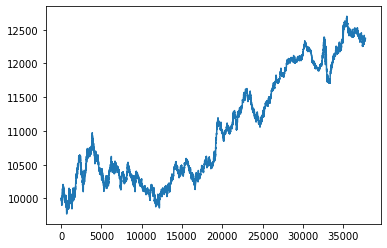

In [28]:
strat.compute_return()
strat.data['return_cumsum'].plot()

In [29]:
strat.granularity = AnnualGranularity.H_1.value
strat.compute_performance()
pd.DataFrame.from_dict(strat.indicators, orient='index')

,0
CAGR,0.03
Volatility,0.06
SharpeRatio,0.42
Calmar,0.07
RiskRewardRatio,2
BreakevenHitRatio,33.3
NbTrades,1885
HitRatio,50.8
Expectancy,1.09
ProfitFactor,1.09


## Analyze features

In [31]:
strat.indicators['idx_wins_buy']

[124,
 194,
 352,
 440,
 526,
 570,
 708,
 1069,
 1097,
 1158,
 1183,
 1205,
 1362,
 1372,
 1413,
 1501,
 1643,
 1751,
 1781,
 1802,
 1827,
 1846,
 1945,
 1957,
 1972,
 2024,
 2048,
 2091,
 2461,
 2484,
 2547,
 2711,
 2755,
 2764,
 2793,
 3012,
 3073,
 3103,
 3323,
 3346,
 3482,
 3569,
 3609,
 3652,
 3804,
 3837,
 3853,
 3872,
 3984,
 4010,
 4049,
 4193,
 4246,
 4299,
 4384,
 4416,
 4634,
 4704,
 4735,
 4796,
 4872,
 4990,
 5042,
 5054,
 5072,
 5241,
 5375,
 5404,
 5477,
 5508,
 5523,
 5618,
 5743,
 5837,
 5893,
 5906,
 5938,
 5963,
 6024,
 6040,
 6217,
 6407,
 6420,
 6545,
 6619,
 6773,
 6785,
 6821,
 6923,
 7057,
 7263,
 7353,
 7435,
 7443,
 7654,
 7678,
 7691,
 7847,
 7876,
 7963,
 7989,
 8064,
 8083,
 8105,
 8145,
 8166,
 8175,
 8195,
 8213,
 8476,
 8659,
 8717,
 9013,
 9047,
 9148,
 9155,
 9229,
 9278,
 9312,
 9319,
 9434,
 9458,
 9502,
 9580,
 9756,
 9790,
 10253,
 10267,
 10368,
 10676,
 10728,
 10780,
 10825,
 11011,
 11103,
 11267,
 11435,
 11459,
 11475,
 11521,
 11595,
 1164

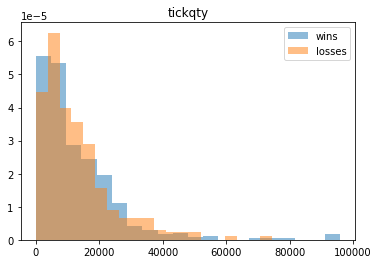

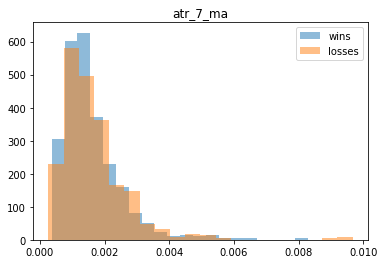

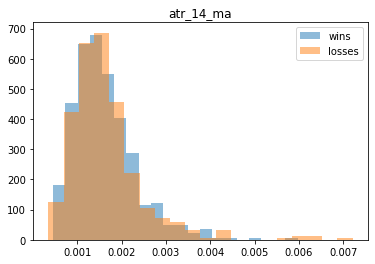

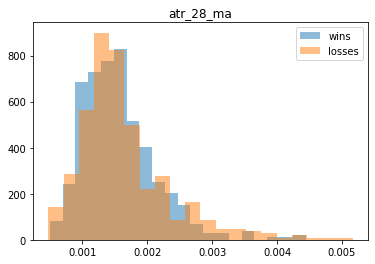

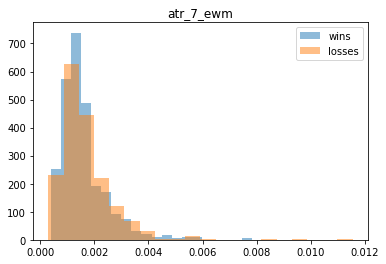

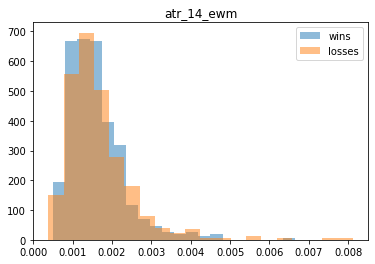

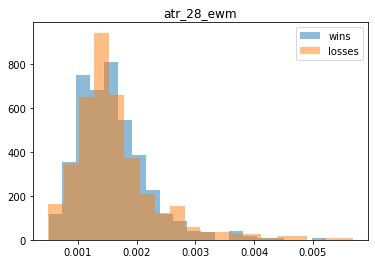

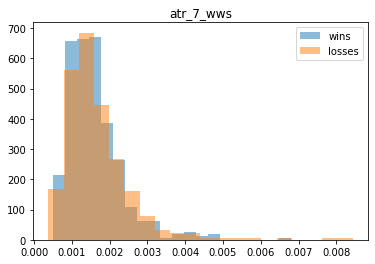

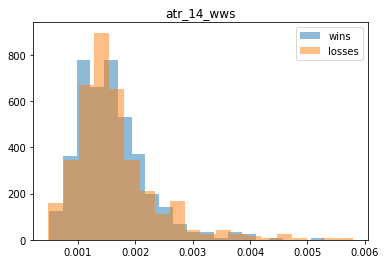

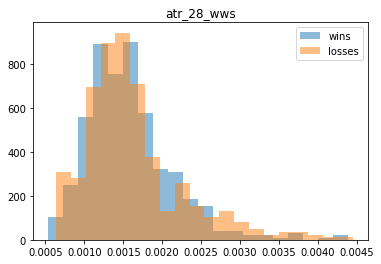

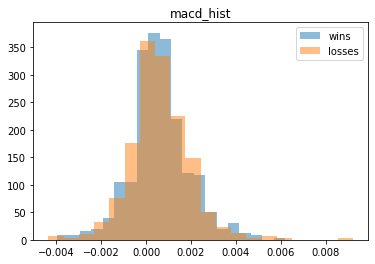

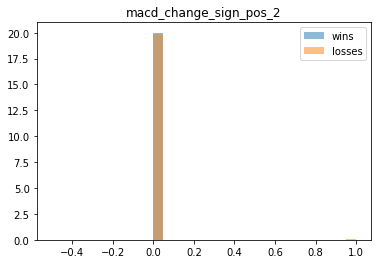

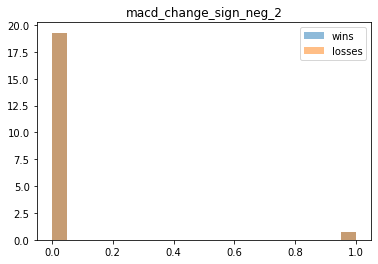

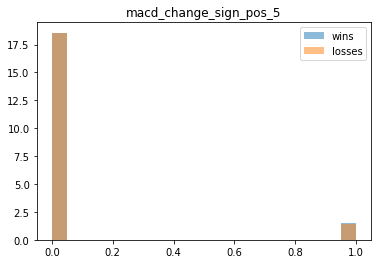

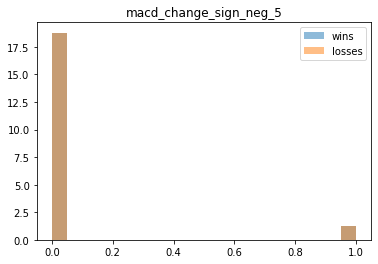

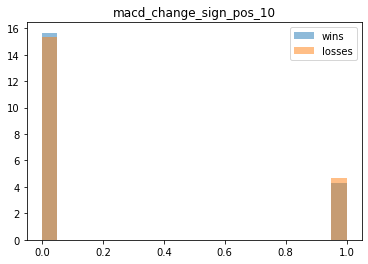

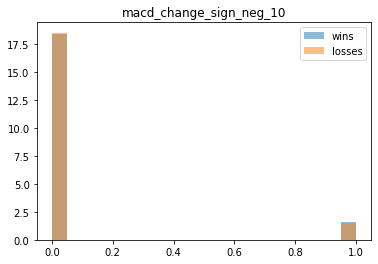

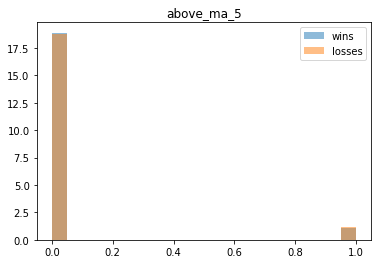

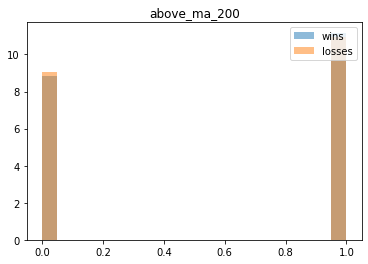

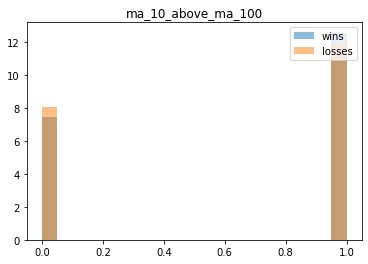

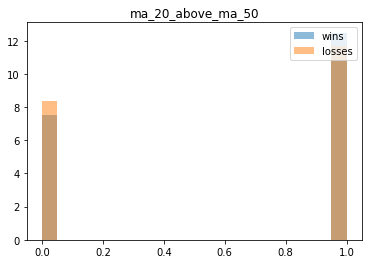

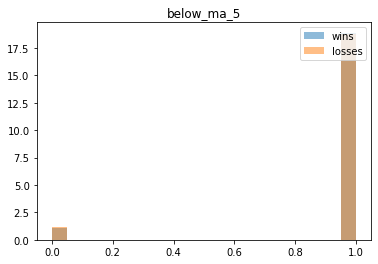

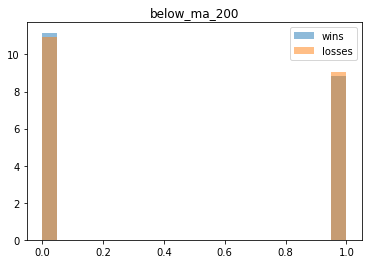

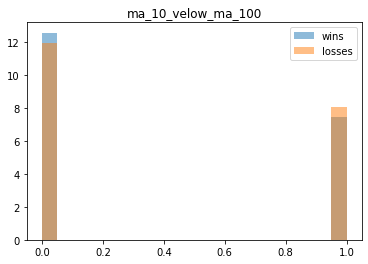

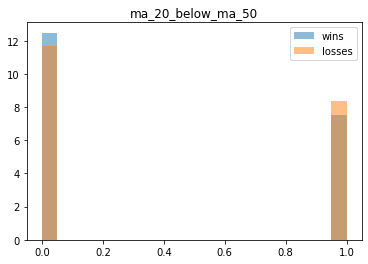

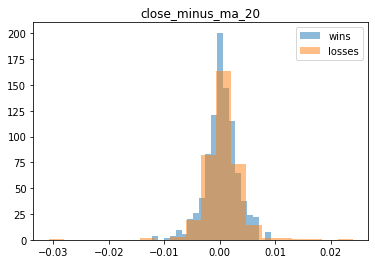

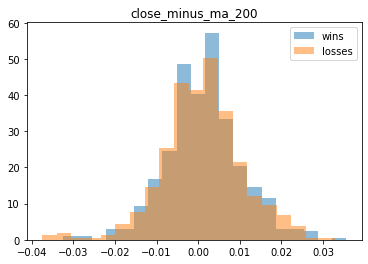

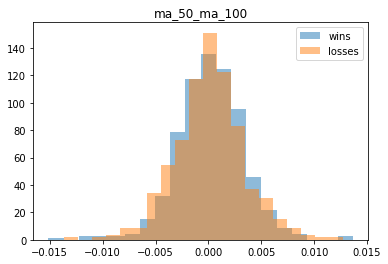

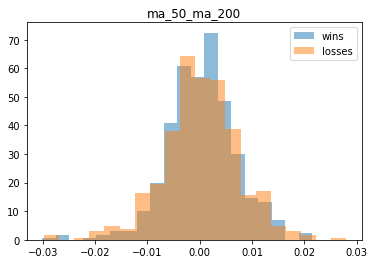

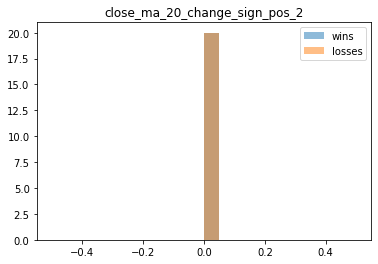

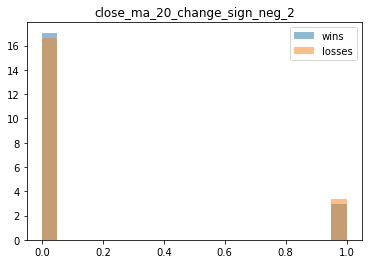

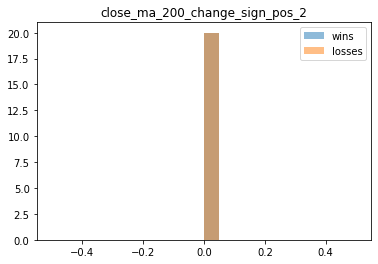

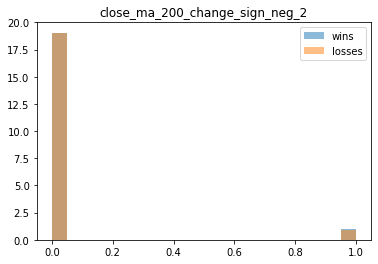

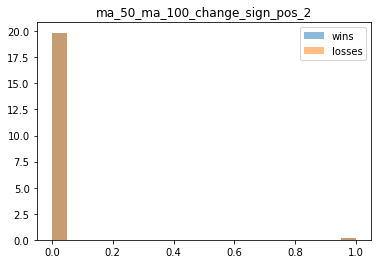

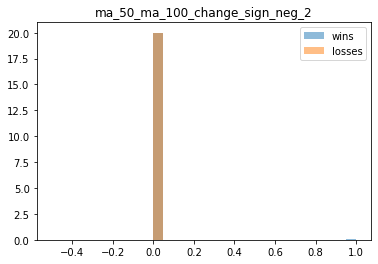

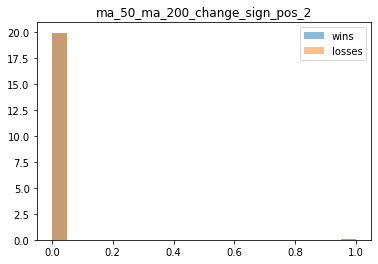

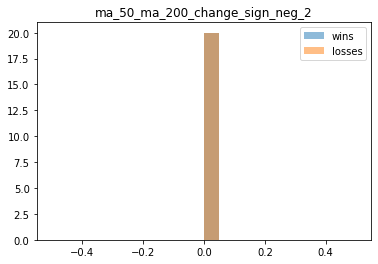

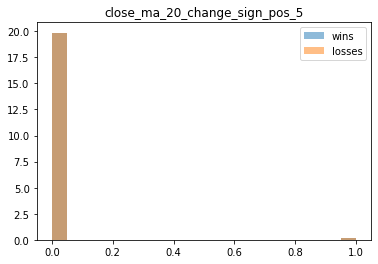

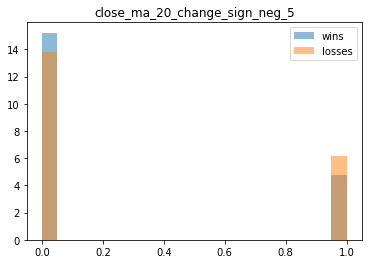

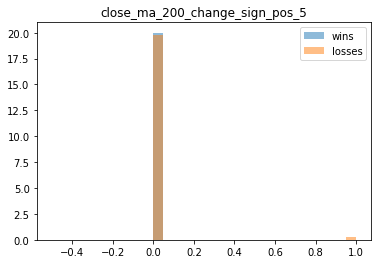

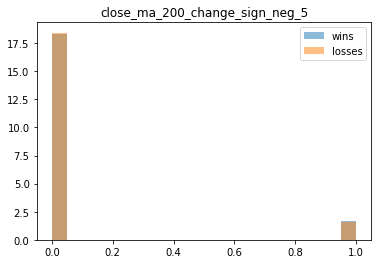

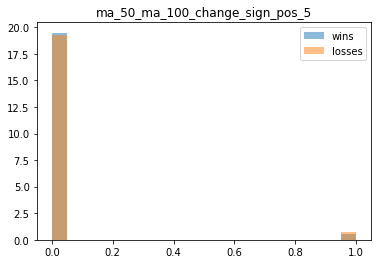

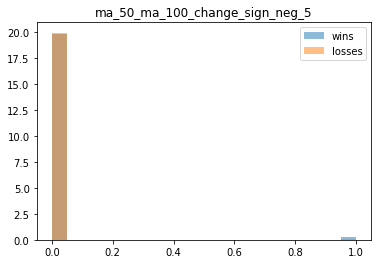

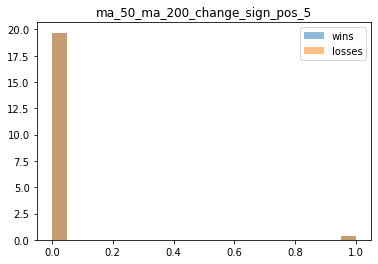

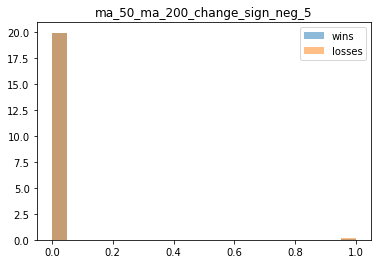

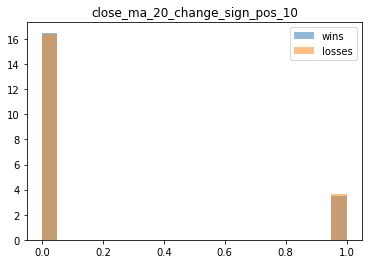

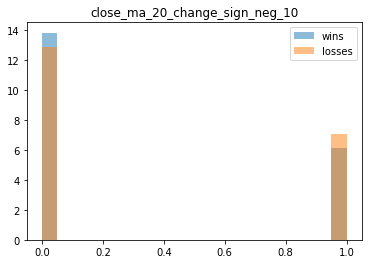

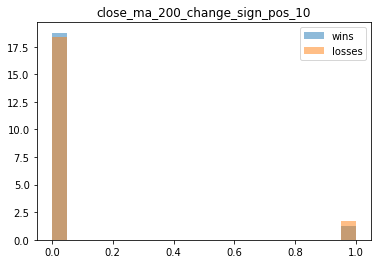

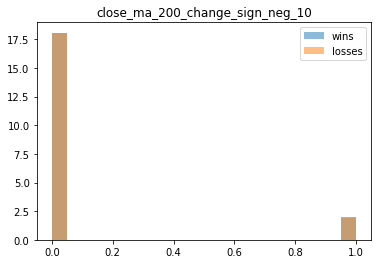

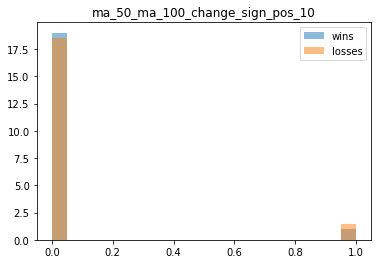

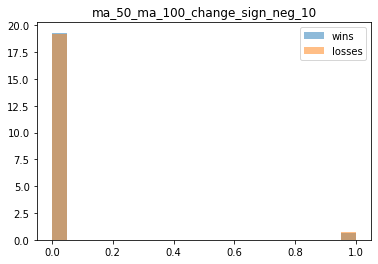

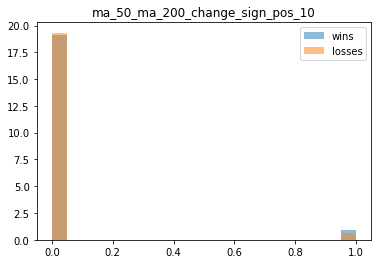

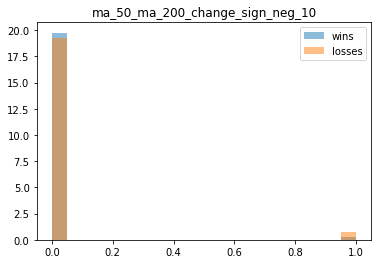

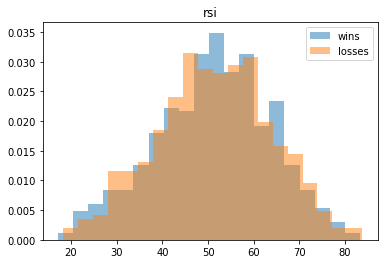

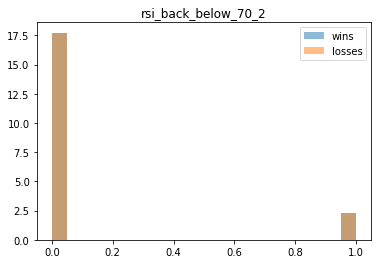

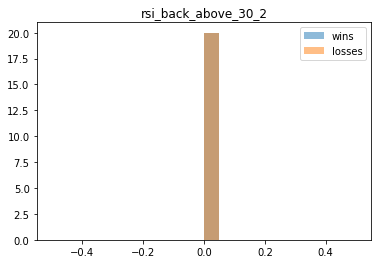

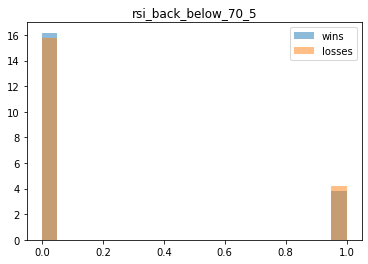

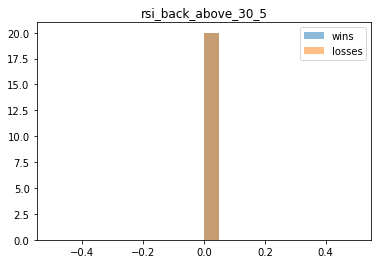

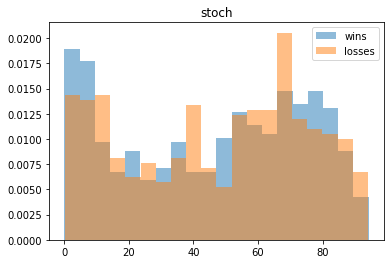

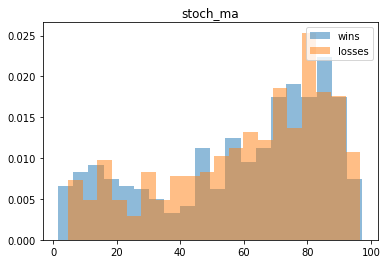

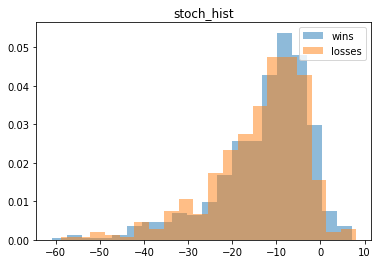

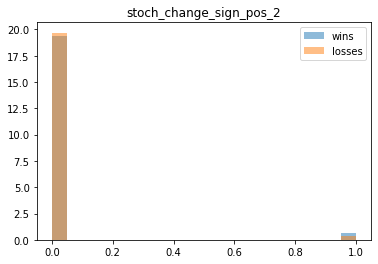

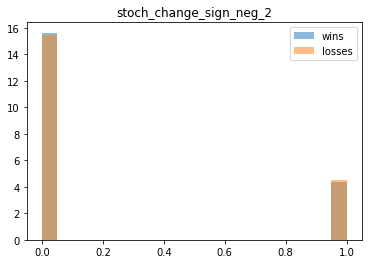

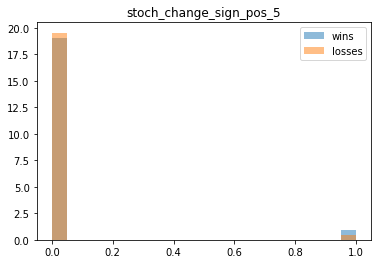

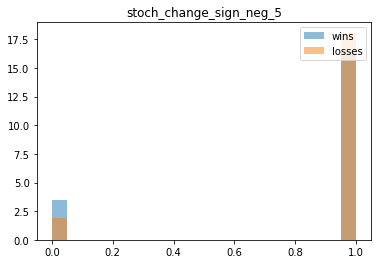

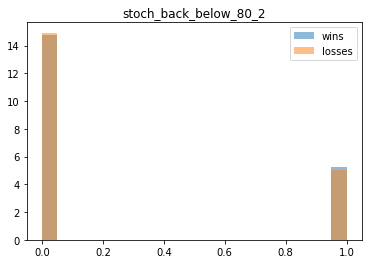

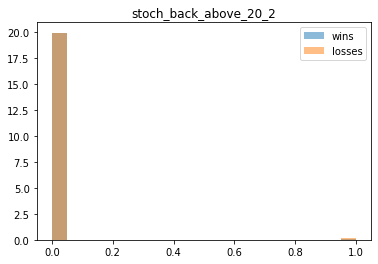

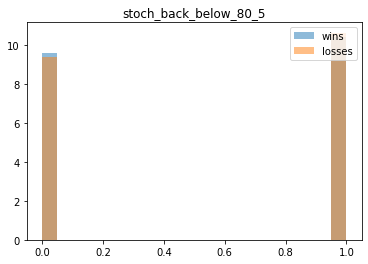

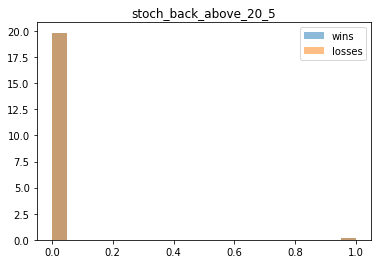

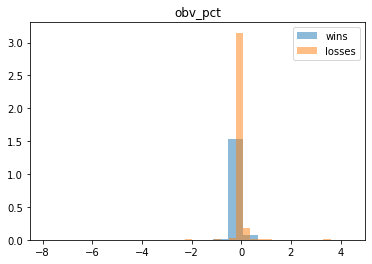

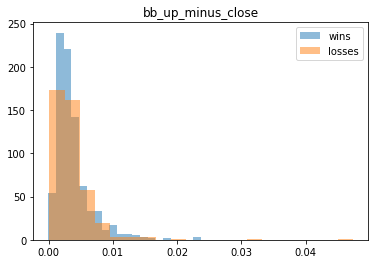

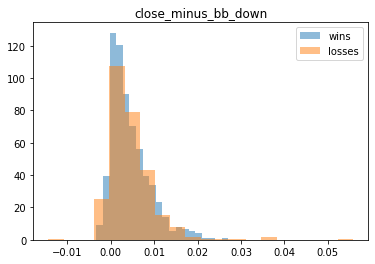

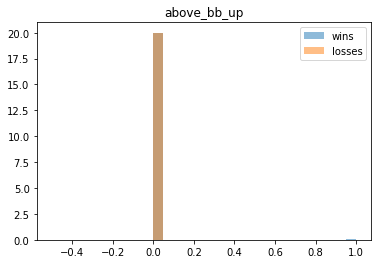

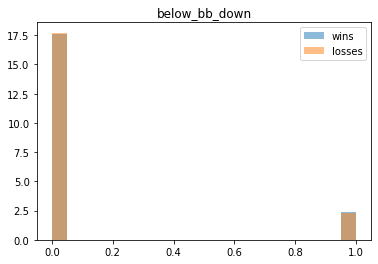

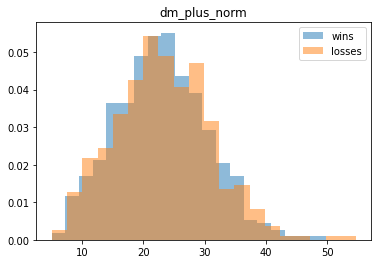

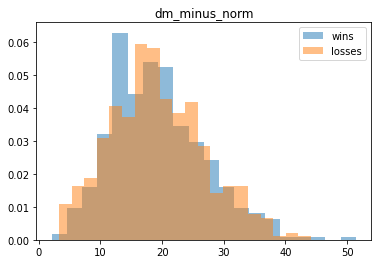

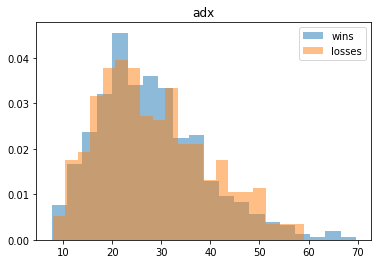

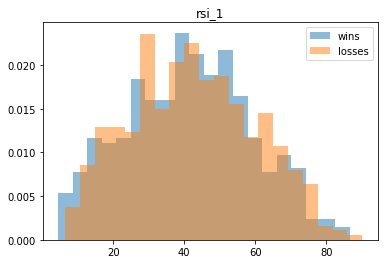

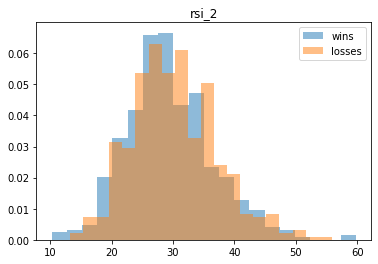

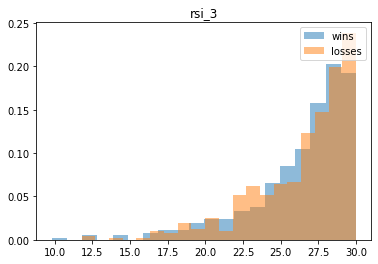

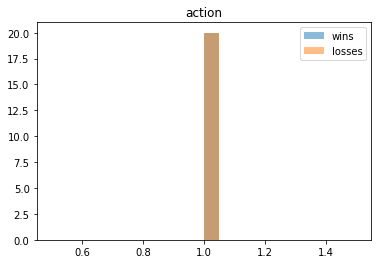

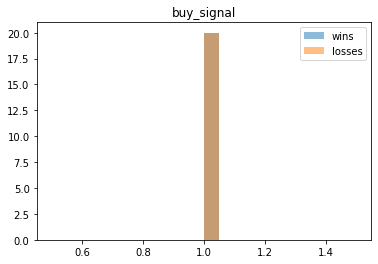

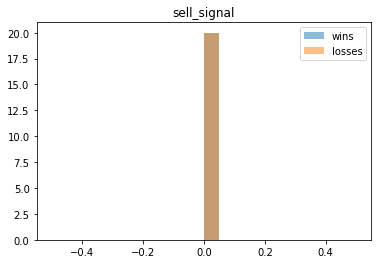

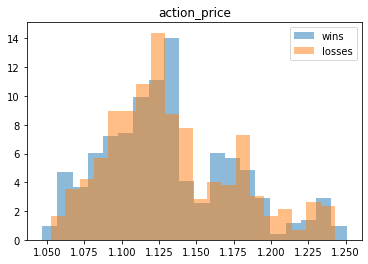

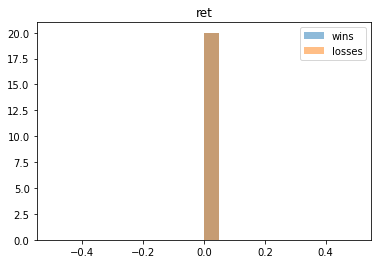

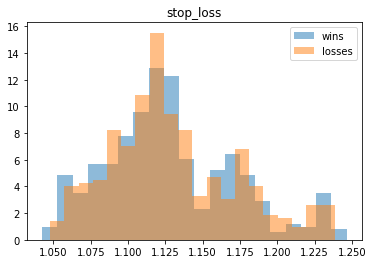

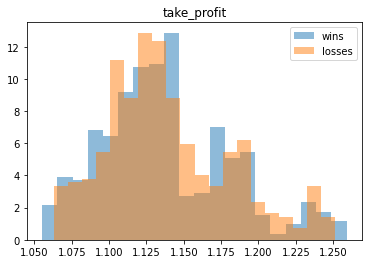

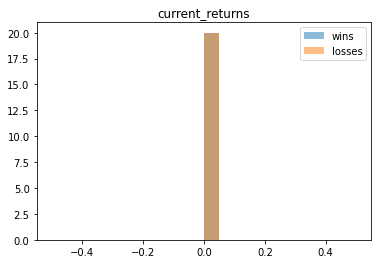

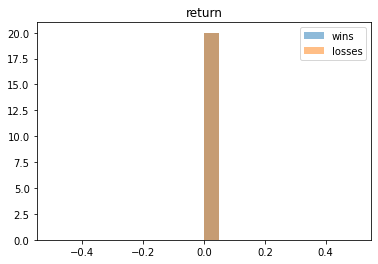

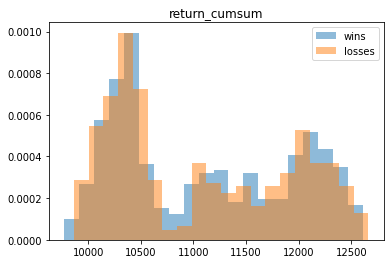

In [43]:
for col in [x for x in strat.data.columns if x not in ['table', 'date', 'symbol', 'open', 'close', 'low', 'high']]:
    wins_col = strat.data.loc[strat.indicators['idx_wins_buy'], col]
    losses_col = strat.data.loc[strat.indicators['idx_losses_buy'], col]
    plt.hist(wins_col, bins=20, alpha=0.5, label='wins', density=True)
    plt.hist(losses_col, bins=20, alpha=0.5, label='losses', density=True)
    plt.legend(loc='upper right')
    plt.title(col)
    plt.show()

In [38]:
strat.data.loc[strat.indicators['idx_wins_buy'], :]

,table,date,symbol,open,close,low,high,tickqty,atr_7_ma,atr_14_ma,atr_28_ma,atr_7_ewm,atr_14_ewm,atr_28_ewm,atr_7_wws,atr_14_wws,atr_28_wws,macd_hist,macd_change_sign_pos_2,macd_change_sign_neg_2,macd_change_sign_pos_5,macd_change_sign_neg_5,macd_change_sign_pos_10,macd_change_sign_neg_10,above_ma_5,above_ma_200,ma_10_above_ma_100,ma_20_above_ma_50,below_ma_5,below_ma_200,ma_10_velow_ma_100,ma_20_below_ma_50,close_minus_ma_20,close_minus_ma_200,ma_50_ma_100,ma_50_ma_200,close_ma_20_change_sign_pos_2,close_ma_20_change_sign_neg_2,close_ma_200_change_sign_pos_2,close_ma_200_change_sign_neg_2,ma_50_ma_100_change_sign_pos_2,ma_50_ma_100_change_sign_neg_2,ma_50_ma_200_change_sign_pos_2,ma_50_ma_200_change_sign_neg_2,close_ma_20_change_sign_pos_5,close_ma_20_change_sign_neg_5,close_ma_200_change_sign_pos_5,close_ma_200_change_sign_neg_5,ma_50_ma_100_change_sign_pos_5,ma_50_ma_100_change_sign_neg_5,ma_50_ma_200_change_sign_pos_5,ma_50_ma_200_change_sign_neg_5,close_ma_20_change_sign_pos_10,close_ma_20_change_sign_neg_10,close_ma_200_change_sign_pos_10,close_ma_200_change_sign_neg_10,ma_50_ma_100_change_sign_pos_10,ma_50_ma_100_change_sign_neg_10,ma_50_ma_200_change_sign_pos_10,ma_50_ma_200_change_sign_neg_10,rsi,rsi_back_below_70_2,rsi_back_above_30_2,rsi_back_below_70_5,rsi_back_above_30_5,stoch,stoch_ma,stoch_hist,stoch_change_sign_pos_2,stoch_change_sign_neg_2,stoch_change_sign_pos_5,stoch_change_sign_neg_5,stoch_back_below_80_2,stoch_back_above_20_2,stoch_back_below_80_5,stoch_back_above_20_5,obv_pct,bb_up_minus_close,close_minus_bb_down,above_bb_up,below_bb_down,dm_plus_norm,dm_minus_norm,adx,rsi_1,rsi_2,rsi_3,action,buy_signal,sell_signal,action_price,ret,stop_loss,take_profit,current_returns,return,return_cumsum
124,candle1h,2015-01-21 15:00:00,EUR/USD,1.16404,1.15876,1.15819,1.16604,30744,0.004633,0.003186,0.002456,0.005702,0.004125,0.003079,0.004272,0.003120,0.002606,0.000835,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0.001334,-0.010682,-0.000246,-0.010981,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,51.531192,1,0,1,0,29.547142,64.599765,-35.052623,0,0,0,1,0,0,1,0,0.110703,0.003606,0.006274,0,0,26.561808,7.436714,20.607512,45.432572,34.281947,29.393826,1,True,False,1.15876,0.0,1.153494,1.169293,0.0,0.0,9954.173880
194,candle1h,2015-01-26 10:00:00,EUR/USD,1.12514,1.12301,1.12276,1.12546,11685,0.003059,0.003196,0.003996,0.003253,0.003354,0.003573,0.003334,0.003564,0.003592,-0.001412,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0.003761,-0.030847,-0.015133,-0.025622,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,50.414993,0,0,0,0,80.073126,88.449211,-8.376085,0,0,0,1,0,0,0,0,0.032454,0.003619,0.011141,0,0,23.134976,21.841333,33.814734,60.932499,44.476033,26.679891,1,True,False,1.12301,0.0,1.115736,1.137557,0.0,0.0,10054.217126
352,candle1h,2015-02-03 22:00:00,EUR/USD,1.14839,1.14649,1.14642,1.14858,3866,0.003193,0.003375,0.002395,0.002661,0.002876,0.002697,0.002877,0.002710,0.002487,0.003957,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0.006310,0.015513,0.002427,0.004807,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68.995653,1,0,1,0,68.333333,73.888889,-5.555556,0,0,0,0,0,0,0,0,0.015769,0.007325,0.019945,0,0,35.019318,9.521925,38.465460,56.237581,22.566639,14.718379,1,True,False,1.14649,0.0,1.141486,1.156497,0.0,0.0,10123.217126
440,candle1h,2015-02-09 11:00:00,EUR/USD,1.13199,1.13120,1.12981,1.13220,16060,0.001991,0.001634,0.002227,0.002089,0.001894,0.001941,0.001903,0.001933,0.002115,-0.001383,0,0,0,0,0,0,0,0,0,0,1,1,1,1,-0.001143,-0.005108,-0.001476,0.002752,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,37.538480,0,0,0,0,24.056604,48.386358,-24.329754,0,0,0,1,0,0,1,0,0.042066,0.004077,0.001792,0,0,16.986897,33.336372,26.951430,30.678004,32.104053,29.805432,1,True,False,1.13120,0.0,1.127017,1.139567,0.0,0.0,10008.373373
526,candle1h,2015-02-13 01:00:00,EUR/USD,1.14011,1.13993,1.13946,1.14036,3080,0.001206,0.002496,0.002181,0.001314,0.001806,0.002054,0.001761,0.002048,0.002080,0.002192,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0.002623,0.003123,0.000815,-0.003047,0,0,0,0,0,0,0,0,

In [37]:
strat.data[strat.data['action'] == 1]

,table,date,symbol,open,close,low,high,tickqty,atr_7_ma,atr_14_ma,atr_28_ma,atr_7_ewm,atr_14_ewm,atr_28_ewm,atr_7_wws,atr_14_wws,atr_28_wws,macd_hist,macd_change_sign_pos_2,macd_change_sign_neg_2,macd_change_sign_pos_5,macd_change_sign_neg_5,macd_change_sign_pos_10,macd_change_sign_neg_10,above_ma_5,above_ma_200,ma_10_above_ma_100,ma_20_above_ma_50,below_ma_5,below_ma_200,ma_10_velow_ma_100,ma_20_below_ma_50,close_minus_ma_20,close_minus_ma_200,ma_50_ma_100,ma_50_ma_200,close_ma_20_change_sign_pos_2,close_ma_20_change_sign_neg_2,close_ma_200_change_sign_pos_2,close_ma_200_change_sign_neg_2,ma_50_ma_100_change_sign_pos_2,ma_50_ma_100_change_sign_neg_2,ma_50_ma_200_change_sign_pos_2,ma_50_ma_200_change_sign_neg_2,close_ma_20_change_sign_pos_5,close_ma_20_change_sign_neg_5,close_ma_200_change_sign_pos_5,close_ma_200_change_sign_neg_5,ma_50_ma_100_change_sign_pos_5,ma_50_ma_100_change_sign_neg_5,ma_50_ma_200_change_sign_pos_5,ma_50_ma_200_change_sign_neg_5,close_ma_20_change_sign_pos_10,close_ma_20_change_sign_neg_10,close_ma_200_change_sign_pos_10,close_ma_200_change_sign_neg_10,ma_50_ma_100_change_sign_pos_10,ma_50_ma_100_change_sign_neg_10,ma_50_ma_200_change_sign_pos_10,ma_50_ma_200_change_sign_neg_10,rsi,rsi_back_below_70_2,rsi_back_above_30_2,rsi_back_below_70_5,rsi_back_above_30_5,stoch,stoch_ma,stoch_hist,stoch_change_sign_pos_2,stoch_change_sign_neg_2,stoch_change_sign_pos_5,stoch_change_sign_neg_5,stoch_back_below_80_2,stoch_back_above_20_2,stoch_back_below_80_5,stoch_back_above_20_5,obv_pct,bb_up_minus_close,close_minus_bb_down,above_bb_up,below_bb_down,dm_plus_norm,dm_minus_norm,adx,rsi_1,rsi_2,rsi_3,action,buy_signal,sell_signal,action_price,ret,stop_loss,take_profit,current_returns,return,return_cumsum
78,candle1h,2015-01-19 17:00:00,EUR/USD,1.16228,1.16101,1.16038,1.16306,8686,0.002401,0.002504,0.002291,0.002467,0.002455,0.002508,0.002457,0.002501,0.002648,0.000949,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0.002369,-0.013670,-0.008207,-0.015559,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54.649149,0,0,0,0,66.057143,79.196557,-13.139414,0,0,0,1,1,0,1,0,0.025875,0.002891,0.007630,0,0,22.667881,14.813652,27.193016,51.118367,34.545309,29.626740,1,True,False,1.16101,0.00000,1.155714,1.171603,0.00000,0.0,9930.873880
79,candle1h,2015-01-19 18:00:00,EUR/USD,1.16101,1.16155,1.16044,1.16178,8012,0.002267,0.002544,0.002206,0.002185,0.002306,0.002427,0.002298,0.002418,0.002601,0.000969,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0.002665,-0.013027,-0.008034,-0.015453,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,56.083063,0,0,0,0,72.228571,72.952381,-0.723810,0,0,0,1,0,0,1,0,-0.023266,0.002662,0.007993,0,0,21.770688,14.227329,26.747438,56.156122,41.844728,39.792967,1,False,False,1.16155,0.00054,1.155714,1.171603,0.00054,5.4,9936.273880
80,candle1h,2015-01-19 19:00:00,EUR/USD,1.16155,1.16029,1.16023,1.16173,6112,0.002111,0.002582,0.002134,0.002014,0.002199,0.002364,0.002184,0.002353,0.002562,0.000874,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0.001201,-0.014174,-0.007902,-0.015372,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51.955175,0,0,0,0,57.828571,65.371429,-7.542857,0,0,0,1,0,0,1,0,0.018171,0.004005,0.006407,0,0,20.779228,14.216976,26.176287,43.177338,30.787825,31.246158,1,False,False,1.16029,-0.00126,1.155714,1.171603,-0.00072,-12.6,9923.673880
81,candle1h,2015-01-19 20:00:00,EUR/USD,1.16029,1.16102,1.16024,1.16116,7151,0.001914,0.002510,0.001978,0.001740,0.002028,0.002264,0.002003,0.002250,0.002503,0.000847,0,0,0,0,1,0,0,0,0,1,1,1,1,0,0.001691,-0.013331,-0.007794,-0.015306,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54.064677,0,0,0,0,66.171429,65.409524,0.761905,1,0,1,0,0,0,1,0,-0.020881,0.003400,0.006782,0,0,20.172432,13.801811,25.645933,51.324553,42.673715,46.644806,1,False,False,1.16102,0.00073,1.155714,1.171603,0.00001,7.3,9930.973880
82,candle1h,2015-01-19 21:00:00,EUR/USD,1.16102,1.16059,1.16057,1.16121,6964,0.001631,0.002334,0.001905,0.001465,0.001843,0.002152,0.001808,0.002135,0.002436,0.000782,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0.001089,-0.013638,-0.

# ML model
## Compute y

In [248]:
stop_gain = 50 * 1e-4
stop_loss = 10 * 1e-4
span = 20
#candles[f'min_{period}'] = np.min(candles['open'].rolling(span, min_periods=span).min(),)

In [249]:
candles_desc = candles[['date', 'open', 'close', 'high', 'low']].sort_values('date', ascending=False)

In [250]:
candles_desc[f'low_{span}'] = candles_desc['low'].rolling(span, min_periods=span).min()
candles_desc[f'high_{span}'] = candles_desc['high'].rolling(span, min_periods=span).max()

In [251]:
mask_buy = (candles_desc[f'high_{span}'] > candles_desc['close'] + stop_gain) & (candles_desc[f'low_{span}'] > candles_desc['close'] - stop_loss)
candles_desc[mask_buy].shape

(12234, 7)

In [252]:
mask_sell = (candles_desc[f'low_{span}'] < candles_desc['close'] - stop_gain) & (candles_desc[f'high_{span}'] < candles_desc['close'] + stop_loss)
candles_desc[mask_sell].shape

(11690, 7)

In [253]:
classes = ['do_nothing', 'buy', 'sell']
candles_desc['y'] = classes.index('do_nothing')
candles_desc.loc[mask_buy, 'y'] = classes.index('buy')
candles_desc.loc[mask_sell, 'y'] = classes.index('sell')

In [254]:
candles['y'] = candles_desc[['date', 'y']].sort_values('date')['y']

## Compute y next up / down

In [485]:
classes = ['sell', 'buy']
close_shift = pd.concat([candles[['date', 'close']].shift(1), candles[['date', 'close']]], axis=1)
close_shift.columns = ['date', 'close', 'next_date', 'next_close']
close_shift['y'] = np.where(close_shift['close'] < close_shift['next_close'], 1, 0)
#del candles['y']
candles = pd.merge(candles, close_shift[['date', 'y']], on='date')
#candles['y'] = [np.NaN] + y[1:-1].tolist() + [np.NaN]

## Split train / test

In [514]:
candles.replace([np.inf, -np.inf], np.nan, inplace=True)
candles.dropna(inplace=True)

In [515]:
train = candles[(candles['date'] >= '2010-01-01') & (candles['date'] < '2016-01-01')]
test = candles[(candles['date'] >= '2016-01-01') & (candles['date'] < '2018-01-01')]

In [516]:
cols = [x for x in candles if x not in ['table', 'date', 'symbol', 'open', 'close', 'low', 'high', 'tickqty', 'y']]
indicators_to_remove = ['obv_pct']
indicators_to_remove = []
cols = [x for x in cols if x not in indicators_to_remove]
y_train, y_test = train['y'], test['y']
X_train, X_test = train[cols], test[cols]

## Train model

In [517]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [524]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier()

In [518]:
mms = MinMaxScaler()
mms.fit(X_train)
X_train_n = mms.transform(X_train)
X_test_n = mms.transform(X_test)

In [519]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_n, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

## Model Performances

In [520]:
from sklearn.metrics import precision_recall_fscore_support

In [526]:
model = rf
X_train_n = X_train
X_test_n = X_test

In [527]:
y_pred = model.predict(X_train_n)
res = precision_recall_fscore_support(y_train, y_pred, average=None)
pd.DataFrame(res, columns=classes, index=['precision', 'recall', 'f1-score', 'avg'])

,sell,buy
precision,1.0,1.0
recall,1.0,1.0
f1-score,1.0,1.0
avg,229836.0,219547.0


In [528]:
y_pred = model.predict(X_test_n)
res = precision_recall_fscore_support(y_test, y_pred, average=None)
pd.DataFrame(res, columns=classes, index=['precision', 'recall', 'f1-score', 'avg'])

,sell,buy
precision,0.525031,0.504304
recall,0.596347,0.432210
f1-score,0.558421,0.465482
avg,77029.000000,73189.000000


In [383]:
feat_importance = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns=['value'])

In [384]:
feat_importance.sort_values('value', ascending=False)

,value
obv_pct,0.480180
stoch_hist,0.099432
stoch_change_sign_pos_5,0.064769
stoch_change_sign_neg_5,0.053147
stoch_change_sign_pos_2,0.029953
below_ma_5,0.028316
above_ma_5,0.025494
stoch_change_sign_neg_2,0.022236
stoch,0.015455
bb_up_minus_close,0.011772


In [299]:
feat_importance.sort_values('value', ascending=False)

,value
obv_pct,0.514871
stoch_hist,0.085798
stoch_change_sign_neg_10,0.062894
stoch_change_sign_pos_5,0.043913
stoch_change_sign_neg_2,0.036039
above_ma_5,0.034260
stoch_change_sign_neg_5,0.022059
stoch_change_sign_pos_2,0.020818
below_ma_5,0.018139
stoch,0.016927
